# Natural Language Processing

Chapter 20 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do). Joel's code: [natural_language_processing.py](https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/natural_language_processing.py)

In [59]:
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import requests
import re
import matplotlib.pyplot as plt

## n-gram models

In [60]:
url = 'http://www.oreilly.com/ideas/what-is-data-science.html'
html = requests.get(url).content

In [61]:
# mydivs = soup.findAll("div", class_="stylelist")
# for div in mydivs: 
#     if (div["class"] == "stylelistrow"):
#         print(div)

In [62]:
soup = BeautifulSoup(html, 'html5lib')
content = soup.findAll("div", class_="stylelistrow")
print(content)

[]


In [63]:
# regex = r"[\w']+|[\.]"
# document = []
# for paragraph in content("p"):
#     words = re.findall(regex, paragraph.text)
#     document.extend(words)

In [64]:
regex = r"[\w']+|[\.]"
document = []
for paragraph in soup.findAll("p"):
    words = re.findall(regex, paragraph.text)
    document.extend(words)

In [65]:
bigrams = zip(document, document[1:])
transitions = defaultdict(list)
for prev, current in bigrams:
    transitions[prev].append(current)

In [66]:
len(transitions)

105

In [67]:
def generate_using_bigrams():
    # this means the next word will start a sentence
    current = "."
    result = []
    
    while True:
        next_word_candidates = transitions[current]
        current = random.choice(next_word_candidates)
        result.append(current)
        if current == ".": return " ".join(result)

In [68]:
generate_using_bigrams()

'For additional help please contact our home TV .'

In [69]:
trigrams = zip(document, document[1:], document[2:])
trigram_transitions = defaultdict(list)
starts = []

In [70]:
for a, b, c in trigrams:
    if a == ".":
        starts.append(b)
    trigram_transitions[(a, b)].append(c)

In [71]:
def generate_using_trigrams():
    current = random.choice(starts)
    prev = "."
    result = [current]

    # choose a random starting word
    # and precede it with a '.'
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        prev, current = current, next_word
        result.append(current)
        
        if current == ".":
            return " ".join(result)

In [72]:
generate_using_trigrams()

'Exercise your consumer rights by contacting us at donotsell oreilly .'

## Grammars

In [73]:
grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

In [74]:
def is_terminal(token):
    return token[0] != "_"

In [75]:
def expand(grammar, tokens):
    for i, token in enumerate(tokens):

        # ignore terminals
        if is_terminal(token): continue

        # choose a replacement at random
        replacement = random.choice(grammar[token])

        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        return expand(grammar, tokens)

    # if we get here we had all terminals and are done
    return tokens

In [76]:
def generate_sentence(grammar):
    return ' '.join(expand(grammar, ["_S"])) + '.'

In [77]:
generate_sentence(grammar)

'big big big linear regression about big regression about big regression near logistic Python about big data science is.'

## Gibbs Sampling

In [78]:
def roll_a_die():
    return random.choice([1,2,3,4,5,6])

In [79]:
def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

In [80]:
td = [s for _, s in (direct_sample() for i in range(1000))]

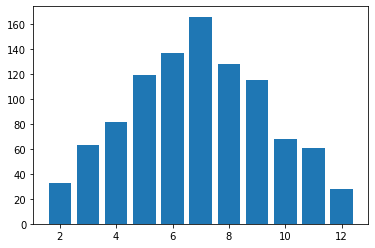

In [81]:
counter = Counter(td)
plt.bar(range(2,13), [counter[i] for i in range(2,13)])
plt.show()

In [82]:
def random_y_given_x(x):
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

In [83]:
def random_x_given_y(y):
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

In [84]:
def gibbs_sample(num_iters=100):
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [85]:
def compare_distributions(num_samples=10000):
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [86]:
counts = compare_distributions()

In [87]:
for d1 in [1,2,3,4,5,6]:
    for d2 in [1,2,3,4,5,6]:
        print(d1,d1+d2,':',counts[(d1,d1+d2)])

1 2 : [276, 281]
1 3 : [286, 308]
1 4 : [264, 290]
1 5 : [297, 292]
1 6 : [268, 257]
1 7 : [283, 258]
2 3 : [279, 268]
2 4 : [281, 298]
2 5 : [259, 303]
2 6 : [301, 264]
2 7 : [225, 271]
2 8 : [308, 273]
3 4 : [265, 271]
3 5 : [269, 266]
3 6 : [310, 259]
3 7 : [301, 293]
3 8 : [266, 288]
3 9 : [265, 268]
4 5 : [277, 276]
4 6 : [293, 286]
4 7 : [278, 292]
4 8 : [261, 274]
4 9 : [270, 271]
4 10 : [287, 284]
5 6 : [264, 279]
5 7 : [278, 266]
5 8 : [263, 289]
5 9 : [265, 271]
5 10 : [288, 266]
5 11 : [248, 267]
6 7 : [294, 303]
6 8 : [290, 268]
6 9 : [273, 246]
6 10 : [284, 280]
6 11 : [280, 304]
6 12 : [304, 270]


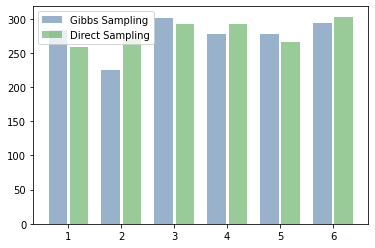

In [88]:
y = 7
p1 = plt.bar([x-0.2 for x in range(1,7)],
        [counts[(i,y)][0] for i in range(1,7)],
        color='#33669980',
        width=0.35)
p2 = plt.bar([x+0.2 for x in range(1,7)],
        [counts[(i,y)][1] for i in range(1,7)],
        color='#33993380',
        width=0.35)
plt.legend((p1[0], p2[0]), ('Gibbs Sampling', 'Direct Sampling'))
plt.show()

## Topic Modeling

In [89]:
def sample_from(weights):
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()
    for i, w in enumerate(weights):
        rnd -= w
        if rnd <= 0: return i

In [90]:
documents = [
        ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
        ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
        ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
        ["R", "Python", "statistics", "regression", "probability"],
        ["machine learning", "regression", "decision trees", "libsvm"],
        ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
        ["statistics", "probability", "mathematics", "theory"],
        ["machine learning", "scikit-learn", "Mahout", "neural networks"],
        ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
        ["Hadoop", "Java", "MapReduce", "Big Data"],
        ["statistics", "R", "statsmodels"],
        ["C++", "deep learning", "artificial intelligence", "probability"],
        ["pandas", "R", "Python"],
        ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
        ["libsvm", "regression", "support vector machines"]
]

In [91]:
document_topic_counts = [Counter() for _ in documents]

In [92]:
K = 4
topic_word_counts = [Counter() for _ in range(K)]

In [93]:
topic_counts = [0 for _ in range(K)]

In [94]:
document_lengths = list(map(len, documents))

In [95]:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

In [96]:
D = len(documents)

In [97]:
document_topic_counts[3][1]

0

In [98]:
topic_word_counts[2]["nlp"]

0

In [99]:
def p_topic_given_document(topic, d, alpha=0.1):
    """the fraction of words in document _d_
    that are assigned to _topic_ (plus some smoothing)"""
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

In [100]:
def p_word_given_topic(word, topic, beta=0.1):
    """the fraction of words assigned to _topic_
    that equal _word_ (plus some smoothing)"""
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

In [101]:
def topic_weight(d, word, k):
    """given a document and a word in that document,
    return the weight for the kth topic"""
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

In [102]:
def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k)
        for k in range(K)])

In [103]:
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
    for document in documents]

In [104]:
for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

In [105]:
for iter in range(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):

            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1
            
            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic
            
            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

In [106]:
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            print(k, word, count)

0 Java 3
0 Big Data 3
0 Hadoop 2
0 HBase 1
0 C++ 1
0 Spark 1
0 Storm 1
0 programming languages 1
0 MapReduce 1
0 Cassandra 1
0 deep learning 1
1 HBase 2
1 neural networks 2
1 Postgres 2
1 MongoDB 2
1 machine learning 2
1 Cassandra 1
1 numpy 1
1 decision trees 1
1 deep learning 1
1 databases 1
1 MySQL 1
1 NoSQL 1
1 artificial intelligence 1
1 scipy 1
2 regression 3
2 Python 2
2 R 2
2 libsvm 2
2 scikit-learn 2
2 mathematics 1
2 support vector machines 1
2 Haskell 1
2 Mahout 1
3 statistics 3
3 probability 3
3 Python 2
3 R 2
3 pandas 2
3 statsmodels 2
3 C++ 1
3 artificial intelligence 1
3 theory 1


In [107]:
for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic, ':', count, '\n')

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
0 : 7 

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
1 : 5 

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
1 : 2 

2 : 2 

3 : 2 

['R', 'Python', 'statistics', 'regression', 'probability']
3 : 3 

2 : 2 

['machine learning', 'regression', 'decision trees', 'libsvm']
2 : 2 

1 : 2 

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
2 : 3 

0 : 3 

['statistics', 'probability', 'mathematics', 'theory']
3 : 3 

2 : 1 

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
2 : 2 

1 : 2 

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
1 : 3 

0 : 1 

['Hadoop', 'Java', 'MapReduce', 'Big Data']
0 : 4 

['statistics', 'R', 'statsmodels']
3 : 3 

['C++', 'deep learning', 'artificial intelligence', 'probability']
3 : 3 

0 : 1 

['pandas', 'R', 'Python']
3 : 3 

['databases', 'HBase', 'Postgres', 'MySQL', 'MongoDB']
1 : 5 

['libsv